In [28]:
# load libraries and set plot parameters
import numpy as np
import pandas as pd
import numpy as np
import scipy.spatial as sp
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tsp.tsp import TravelingSalesmanProblem
import tsp.tsp_heuristic as th

In [3]:
def build_plot(heuristic_result):
    start = heuristic_result.get_starting_node_for_plotting()
    x, y = np.array(heuristic_result.get_cycle_for_plotting()).T
    plt.rcParams['figure.figsize'] = (14, 9)
    plt.plot(x, y)
    plt.plot(start[0], start[1], "ro")
    plt.title("Distance travelled: {0:.1f}".format(
        heuristic_result.loss()))
    plt.axis('off')
    plt.show()

# Traveling Salesman Problem

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Data-structures" data-toc-modified-id="Data-structures-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data structures</a></span></li><li><span><a href="#Construction-heuristics" data-toc-modified-id="Construction-heuristics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Construction heuristics</a></span><ul class="toc-item"><li><span><a href="#Best-Insertion" data-toc-modified-id="Best-Insertion-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Best Insertion</a></span></li><li><span><a href="#Best-Best-Insertion" data-toc-modified-id="Best-Best-Insertion-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Best-Best Insertion</a></span></li><li><span><a href="#Shortest-Edge" data-toc-modified-id="Shortest-Edge-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Shortest Edge</a></span></li></ul></li><li><span><a href="#Improvement-heuristics" data-toc-modified-id="Improvement-heuristics-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Improvement heuristics</a></span><ul class="toc-item"><li><span><a href="#Greedy-Local-Search" data-toc-modified-id="Greedy-Local-Search-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Greedy Local Search</a></span></li><li><span><a href="#Simulated-Annealing" data-toc-modified-id="Simulated-Annealing-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Simulated Annealing</a></span></li></ul></li></ul></li><li><span><a href="#Pairwise-comparison" data-toc-modified-id="Pairwise-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pairwise comparison</a></span></li></ul></div>

## Introduction

The traveling salesman problem is an optimisation problem for which to date no analytical solution has been found. It describes a network of nodes that have to be connected in a tour so that the path connecting all nodes is as short as possible. Each node can only be visited once and thus has exactly two connecting edges.

There are two main families of heuristics for solving the problem. The construction heuristics start with one or a few nodes drawn at random and build the tour from there. The algorithm stops when all nodes are connected in the tour. The family of improvement heuristics start with a randomly chosen tour and then look for possible improvements using several different strategies. The algorithm stops after a certain number of executions.

In the scope of this project, the following heuristics will be showcased:

* Construction heuristics
    * Best insertion
    * Best-best insertion
    * Shortest Edge
* Improvement heuristics
    * Greedy local search with the moves:
        * Swaping
        * Translation
        * Inversion
        * Mixed move
    * Simulated Annealing with the criteria
        * Metropolis
        * Heat bath

## Implementation

### Data structures

Three classes represent the network on which heuristics operate. These are:

* Node: A vertex in the network with x- and y-coordinates and a number
* Edge: A line connecting two nodes with a length (*cost*/*distance*)
* TravelingSalesmanProblem: Has a list of all nodes in the network, holds the distance matrix describing the distance between any two nodes in the network and has a distance metric registered used to compute the distance matrix.

In [4]:
"""This module implements data structures for a traveling salesman problem."""
import scipy.spatial as sp
import functools
import numpy as np
import pandas as pd

from collections import namedtuple


class Node:
    """Represents one node in the network.

    Parameters:
    -----------

    node:   A named tuple with fields 'node', 'x' and 'y'
    """

    def __init__(self, node):
        self.node = int(node['node'])
        self.x = int(node['x'])
        self.y = int(node['y'])

    @property
    def coords(self):
        "Returns the coordinates for the node"
        return (self.x, self.y)


@functools.total_ordering
class Edge:
    """Represents an edge, the connecting line terminated by two nodes."""

    def __init__(self, node1, node2, tsp_config):
        self.tsp = tsp_config
        self.node1 = node1
        self.node2 = node2
        self.edge = self.tsp.distance_matrix[node1, node2]

    def __repr__(self):
        return "{}: nodes: ({}, {}). Length: {}".format(self.__class__.__name__,
                                                        self.node1, self.node2,
                                                        self.edge)

    def __lt__(self, other):
        return self.edge < other.edge

    def __eq__(self, other):
        return self.edge == other.edge

    @property
    def length(self):
        return self.edge


class TravelingSalesmanProblem:
    """Holds the nodes and distance matrix for a traveling salesman problem.
    It also provides methods for calculating the distance between nodes.

    Parameters:
    -----------

    nodes:              a pandas dataframe with columns [node, x, y]
    distance_matrix:    an nxn symmetric matrix with the distances between nodes.
                        If not passed, it is constructed using an L2 distance metric by default.
    distance_metric:    The metric used to calculate distances in the network.
                        Has to accept the coordinates of two nodes as parameters
    """

    def __init__(self, nodes=None, distance_metric=sp.distance.euclidean):
        self._nodes = dict([[i, Node(nodes.iloc[i, :])]
                            for i in range(len(nodes))]) if nodes is not None else None
        if nodes is not None:
            self.build_distance_matrix()
        else:
            self._distance_matrix = None
        self._distance_metric = distance_metric

    @property
    def nodes(self):
        return self._nodes

    @nodes.setter
    def nodes(self, nodes):
        if isinstance(nodes, pd.DataFrame):
            self._nodes = dict([[i, Node(nodes.iloc[i, :])]
                                for i in range(len(nodes))])
        else:
            return False

    @property
    def distance_matrix(self):
        if self._distance_matrix is None:
            self.build_distance_matrix()
        return self._distance_matrix

    @distance_matrix.setter
    def distance_matrix(self, distance_matrix):
        assert isinstance(distance_matrix, np.ndarray)
        self._distance_matrix = distance_matrix

    def calc_distance(self, c1, c2):
        return self._distance_metric([c1.x, c1.y], [c2.x, c2.y])

    def build_distance_matrix(self):
        assert self.nodes is not None
        coords = [self.nodes[i].coords for i in range(len(self.nodes))]
        self._distance_matrix = sp.distance_matrix(coords, coords, p=2)

In [5]:
nodes = pd.read_csv("TSP_411.txt", sep='\s+', names=['node', 'x', 'y'])

The network consists of {{len(nodes.index)}} nodes. The nodes are read in from a csv file. The three columns {{list(nodes.columns.values)}} in the file represent the node number and the coordinates of a given node. The unconnected nodes are shown in Figure .

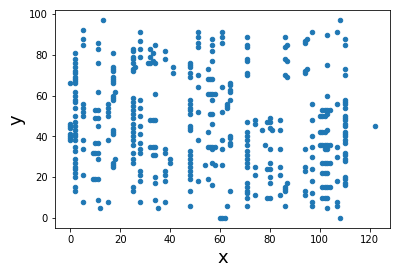

In [6]:
nodes.plot(kind='scatter', x='x', y='y',)

In [7]:
tsp = TravelingSalesmanProblem(nodes)

###  Construction heuristics

#### Best Insertion

The best insertion heuristic starts with 3 randomly chosen nodes. It then randomly selects the next node not included in the tour and finds the pair of nodes between which insertion results in the smallest increase in tour length.

This strategy can be seen as a global optimization.

In [8]:
bestinsert = th.BestInsertion(tsp)

In [9]:
bestinsert.calculate_cycle()

1520.783190737111

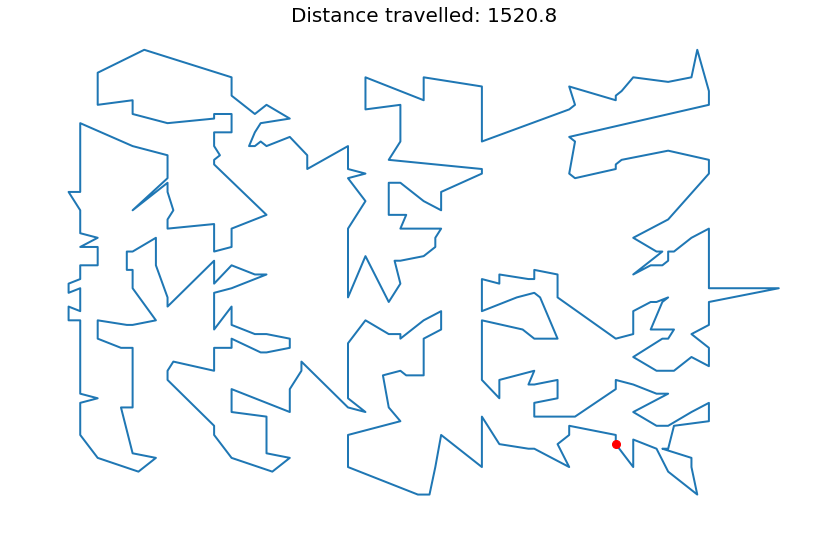

In [10]:
build_plot(bestinsert)

#### Best-Best Insertion

In [11]:
bbinsert = th.BestBestInsertion(tsp)

In [12]:
bbinsert.calculate_cycle()

1949.3536648113015

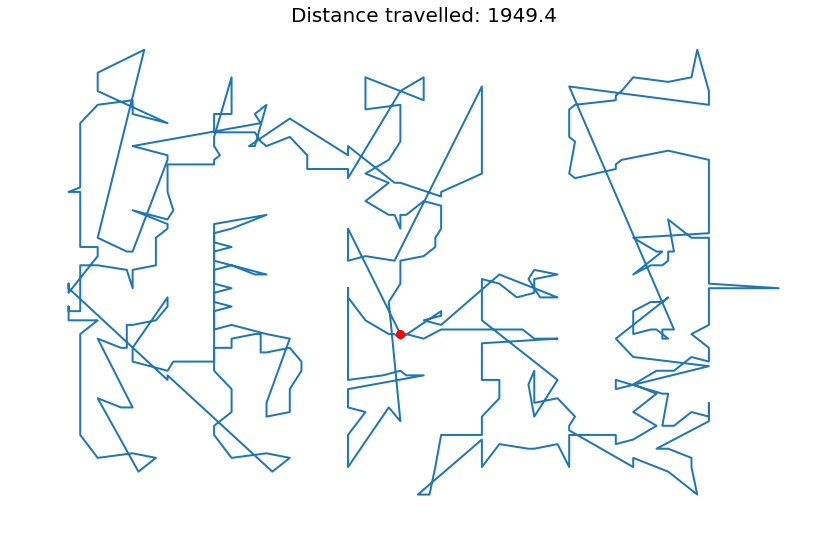

In [13]:
build_plot(bbinsert)

#### Shortest Edge

The shortest edge works on a list of all possible $n(n-1)$ edges between the nodes in the network. The edges are first sorted by length. Subsequently, the shortest edge is selected as the starting point. From there, the sorted list is searched for the next node meeting the two constraints:

1. Inserted edge does not produce a look that is shorter than the one connecting all nodes
2. The two nodes at the endpoints of the edge do not have more than 2 connected edges after insertion

The algorithm is repeated until the number of edges is equal to the number of edges connecting all nodes in the network.

In [14]:
shortestedge = th.ShortestEdge(tsp)
shortestedge.calculate_cycle()

1696.9338958398457

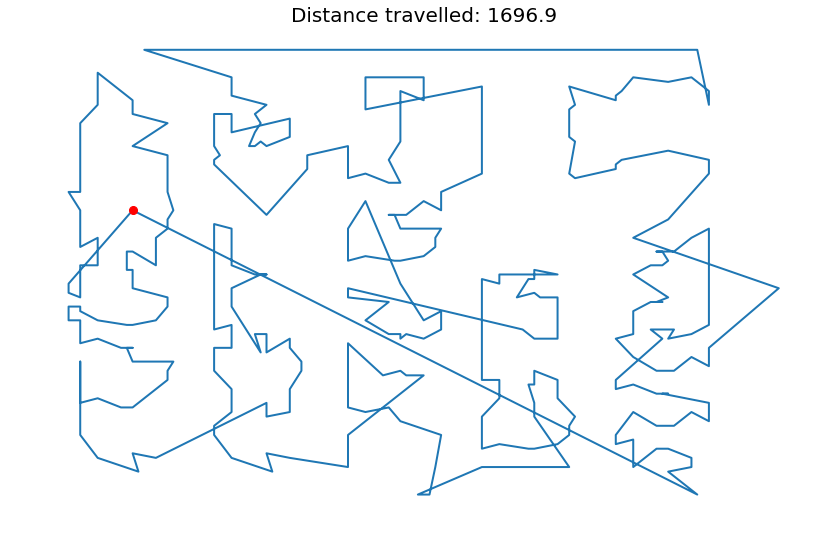

In [15]:
build_plot(shortestedge)

### Improvement heuristics

The family of improvement heuristics starts with a randomly constructed tour and seeks to improve the loss by performing various operations. The stopping criterion here is a fixed number of improvement operations.

#### Greedy Local Search

Starting with the random tour, randomly selected nodes are subjected to one of several possible moves. The loss with the move applied is compared to the previous loss and if smaller, the new tour is accepted.

##### Tranlate

In [16]:
gls_trans = th.GreedyLocalSearch(tsp, th.Translate)
gls_trans.calculate_cycle()

2102.4333858689283

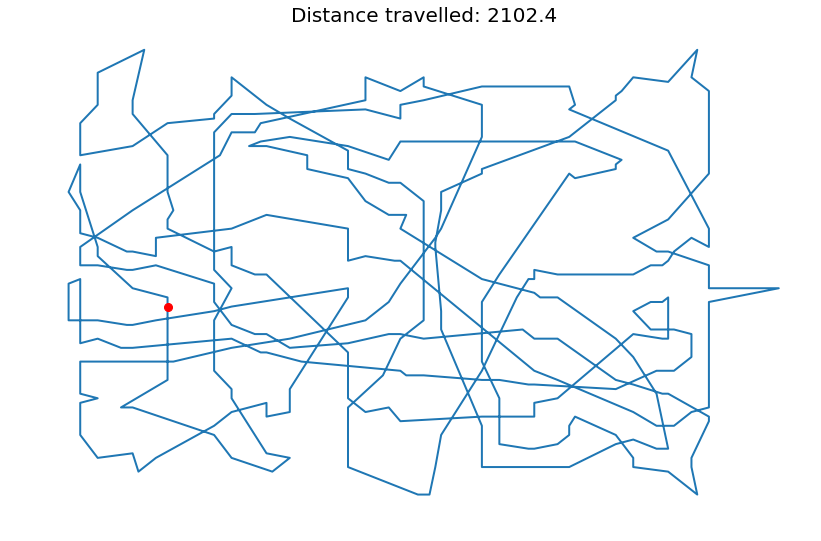

In [17]:
build_plot(gls_trans)

##### Swap

In [ ]:
gls_swap = th.GreedyLocalSearch(tsp, th.Swap)
gls_swap.calculate_cycle()

In [ ]:
build_plot(gls_swap)

##### Invert

In [ ]:
gls_inv = th.GreedyLocalSearch(tsp, th.Invert)
gls_inv.calculate_cycle()

In [ ]:
build_plot(gls_inv)

##### Mixed moves

In [ ]:
gls_mixed = th.GreedyLocalSearch(tsp, th.Mixed)
gls_mixed.calculate_cycle(save_steps=True)

In [ ]:
build_plot(gls_mixed)

### Simulated Annealing

This heuristic mimics the physical process of annealing metals. At a higher temperature, locally modified cycles have a higher probability of being accepted, so we deliberately accept solutions that increase loss, albeit with a relatively small probability.
The temperature is then gradually decreased, raising the bar for accepting new cycles. When the low temperature is reached, the algorithm stops.

There are two conditions for accepting new cycles:

* Metropolis: This condition accepts all cycles with an improved loss and those with a larger loss at probability [INSERT FORMULA]
* Heatbath: The heatbath condition does not automatically accept cycles with a lower loss.

In [ ]:
sa = th.SimulatedAnnealing(tsp)
sa.calculate_cycle()

In [ ]:
build_plot(sa)

## Pairwise comparison

In [ ]:
import pickle

runs_file = Path('./runs.pkl')
if runs_file.is_file():
    with open(runs_file, 'rb') as input:
        runs = pickle.load(input)
else:
    n_runs = 30
    runs = {
        'BestInsertion': [],
        'BestBestInsertion': [],
        'ShortestEdge': [],
        'GreedyLocalSearchSwap': [],
        'GreedyLocalSearchTranslate': [],
        'GreedyLocalSearchInvert': [],
        'GreedyLocalSearchMixed': [],
        'SimulatedAnnealingMetropolis': [],
        'SimulatedAnnealingHeatBath': []
    }

    for i in range(n_runs):
        heuristics = [
            th.BestInsertion(tsp),
            th.BestBestInsertion(tsp),
            th.ShortestEdge(tsp),
            th.GreedyLocalSearchSwap(tsp),
            th.GreedyLocalSearchTranslate(tsp),
            th.GreedyLocalSearchInvert(tsp),
            th.GreedyLocalSearchMixed(tsp),
            th.SimulatedAnnealingMetropolis(tsp),
            th.SimulatedAnnealingHeatBath(tsp)
        ]
        for h in heuristics:
            h.calculate_cycle()
            runs[h.__class__.__name__].append([h.loss(), h.get_cycle()])
            print("Iteration {}: {} done".format(i+1, h.__class__.__name__))
    with open('./runs.pkl', 'wb') as output:
        pickle.dump(runs, output)

Iteration 1: BestInsertion done
Iteration 1: BestBestInsertion done
Iteration 1: ShortestEdge done
Iteration 1: GreedyLocalSearchSwap done
Iteration 1: GreedyLocalSearchTranslate done
